https://www.kaggle.com/code/tarekhikal/text-generation-with-tensorflow-nlp-rnn/notebook

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [2]:
strategy = tf.distribute.MirroredStrategy()
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Dataset Preparation and Preprocessing

In [3]:
import os
os.chdir('E:\Python code\BBC文章全文和类别')
data = pd.read_csv('Shakespeare_data.csv')

In [4]:
data.shape

(111396, 6)

In [5]:
df = data.head(10000).copy()

In [6]:
df.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


# Removing Irrelevant Columns¶
As you can see, the current dataset contains information that is not useful for a language model. Our primary focus here is training our model on conversations/text to generate new text based on it, and the 'Playerline' column provides the relevant data. Therefore, we'll create our base dataset based on that.

In [7]:
dataset = df['PlayerLine']

In [8]:
corpus = []
with strategy.scope():  # 在strategy定义的上下文中执行以下代码
    for line in dataset:  # 遍历数据集中的每一行
        lowercase_line = line.lower()  # 将当前行转换为小写
        corpus.append(lowercase_line)  # 将小写行添加到corpus列表中

In [9]:
corpus[:10]

['act i',
 'scene i. london. the palace.',
 'enter king henry, lord john of lancaster, the earl of westmoreland, sir walter blunt, and others',
 'so shaken as we are, so wan with care,',
 'find we a time for frighted peace to pant,',
 'and breathe short-winded accents of new broils',
 'to be commenced in strands afar remote.',
 'no more the thirsty entrance of this soil',
 "shall daub her lips with her own children's blood,",
 'nor more shall trenching war channel her fields,']

# Initialize Tokenizer

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [11]:
word_to_token = tokenizer.word_index

In [12]:
def key_pair(num):    
    count=0
    for key, value in word_to_token.items():
        if count>=num: break
        print(f''''{key:}': {value},''')
        count +=1
key_pair(10)

'and': 1,
'the': 2,
'of': 3,
'i': 4,
'to': 5,
'a': 6,
'my': 7,
'in': 8,
'that': 9,
'with': 10,


In [13]:
total_words = len(word_to_token)+1
print(total_words)

7857


Sequence-to-N-gram

In [14]:
input_sequences = []
with strategy.scope():
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

In [15]:
len(input_sequences)

66423

In [16]:
input_sequences[:5]

[[454, 4], [139, 4], [139, 4, 234], [139, 4, 234, 2], [139, 4, 234, 2, 589]]

In [17]:
before = input_sequences[1]

In [18]:
max_seq_len = max(len(x) for x in input_sequences)
print(max_seq_len)

56


# Padding¶
Now, the issue with the n-grams we've created is that not all entries have the same length. When dealing with matrix manipulation, consistency in size and shape is crucial. To address this, we'll add padding with 'zero' values to each sequence to make them the same size. This is where our maximum sequence length comes in handy.

You might wonder why we're adding zeros before the original sequence. I'll answer that in a few cells.

In [19]:
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_seq_len, padding = 'pre'))

In [20]:
after = input_sequences[1]

In [21]:
print(f'Before: {before}')
print(f'After: {after}')

Before: [139, 4]
After: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 139   4]


# Creating Feature-Label Pairs¶
Now that we've prepared our corpus, we can focus on creating the actual dataset, consisting of feature-label pairs. We'll need this dataset to train our model to generate text.

Remember the question about why we're adding padding in front of the original sequence? It's because we're going to construct the training set by making the last value of a sequence the label and the rest of the sequence the feature. We're training the model to predict which word typically follows certain structures. Once the training is complete, the model should be able to generate text.

In [22]:
features, labels = input_sequences[:, :-1], input_sequences[:, -1]

In [23]:
labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Handling Out Of Memory Problem¶
Unfortunately, after the n-gram conversion, the dataset becomes extremely large, making it challenging to run on Kaggle's basic resources. To mitigate this, we'll select a tiny portion of the data for our training, approximately 0.05% of the total sequences.

In [26]:
with strategy.scope():
    n = 0.05 # We are only taking a chunk of this huge dataset to fit it on the RAM
    slice_size = int(len(features)*n)
    np.save('kaggle/features', features[:slice_size, :])
    np.save('kaggle/labels', labels[:slice_size, :])

In [28]:
with strategy.scope():
    features = np.load('kaggle/features.npy')
    labels = np.load('kaggle/labels.npy')

# Model Design
This is the model that will learn how to generate text. It takes sequences of words, embeds them into vectors, processes them with Bidirectional LSTMs, and predicts the next word using a softmax output layer.

In [29]:
#Create the model!
def generator_model():
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length = max_seq_len-1)),
    model.add(Bidirectional(LSTM(64, return_sequences = True))),
    model.add(Bidirectional(LSTM(32))),
    model.add(Dense(64, activation = 'relu')),
    model.add(Dense(total_words, activation = 'softmax'))
    return model

Compliling the Model

In [30]:
with strategy.scope():
    model = generator_model()
    model.compile(loss = 'categorical_crossentropy', 
                 optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002),
                 metrics = ['accuracy'])

D:\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
EPOCHS = 10
history = model.fit(features, labels, epochs = EPOCHS)


Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.0307 - loss: 7.9723
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.0362 - loss: 6.2069
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.0423 - loss: 6.0642
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.0579 - loss: 5.9650
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.0626 - loss: 5.8797
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.0679 - loss: 5.8105
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.0712 - loss: 5.7209
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.0705 - loss: 5.6390
Epoch 9/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.0715 - loss: 5.5654
Epoch 10/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.0763 - loss: 5.5022


# Loss Accuracy Curve

In [33]:
#Helper function
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

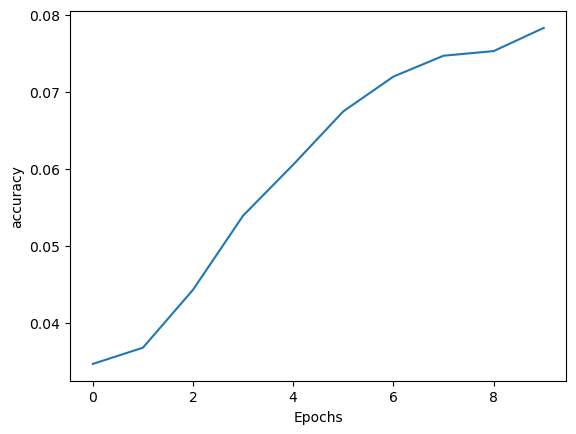

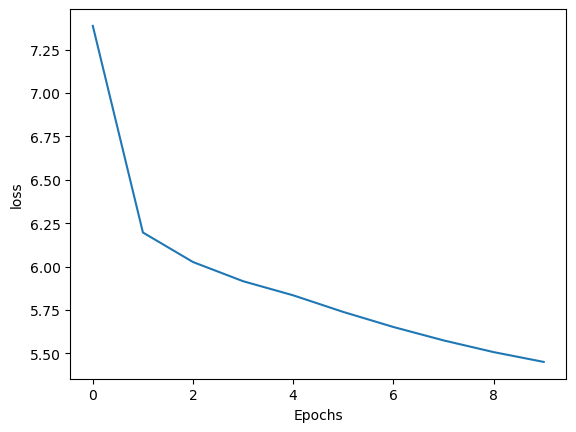

In [34]:
plot_graph(history, 'accuracy')
plot_graph(history, 'loss')

In [35]:
model.save('kaggle/test_generator.h5')
#load the save model if you want to skip the training
#tf.keras.models.load_model('/kaggle/working/test_generator.h5') 

文本生成

In [36]:
def test_generator(string, num):
    if len(string)==0:
        print("Error: No word found")
        return
    for _ in range(num):
        token_list = tokenizer.texts_to_sequences([string])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding = "pre")
        probabilities = model.predict(token_list)
        choice = np.random.choice([1,2,3])
        predicted = np.argsort(probabilities, axis = -1)[0][-choice]
        if predicted !=0:
            generated_word = tokenizer.index_word[predicted]
            string += " " + generated_word
    print(string)

In [37]:
test_generator("long live the king", 20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
long live the king i the devil the lord i the lord i be lord i the devil the lord i i be devil


In [38]:
test_generator("Life", 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Life of the devil i be


In [10]:
   def outer_function():
       outer_var = "I'm in outer function"
       def inner_function():
           nonlocal outer_var
           outer_var = "I've been changed in inner function"
       inner_function()
       print(outer_var)  # 输出"I've been changed in inner function"

   outer_function()

I've been changed in inner function
